In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
from scipy.sparse.linalg import eigsh


from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

def compute_moments(psi, H):
    E = (psi.conj().T @ H.dot(psi)).real
    S = (psi.conj().T @ (H @ H).dot(psi)).real
    return E, S, S - E**2

In [178]:
def create_heisenberg_hamiltonian_(G, J):
    H = sum(J*( X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) ) for (i,j) in G.edges())
    return H

def calculate_spectra(L):
    G = nx.Graph()
    G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

    J = 1
    H = create_heisenberg_hamiltonian_(G, J)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')
    return eigenvalues, eigenvectors

x_val=list(range(4,22,2))

spectra = dict()
for L in x_val:
    spectra[L] = calculate_spectra(L) 

E0_val = dict()
E1_val = dict()
E0_vec = dict()
E1_vec = dict()

for L in x_val:
    E0_val[L] = spectra[L][0][0]
    E1_val[L] = spectra[L][0][1]

    E0_vec[L] = spectra[L][1][:,0]
    E1_vec[L] = spectra[L][1][:,1]

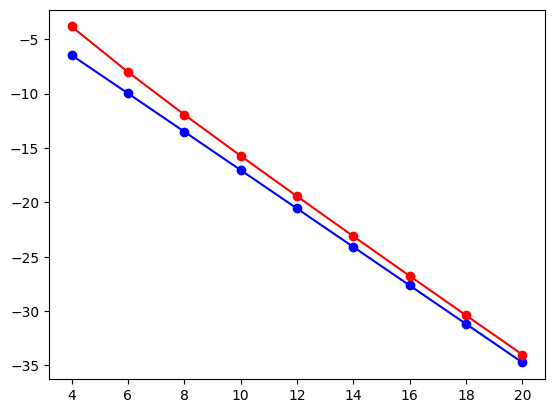

In [ ]:
plt.plot(x_val, list(E0_val.values()), color='blue', marker='o', linestyle='solid')
plt.plot(x_val, list(E1_val.values()), color='red', marker='o', linestyle='solid')

In [ ]:
# Load data (transpilation to {CX,U3}), 2 steps 2nd order Trotterization
results_10 = load_data('data/benchmarks_2nd_L=10_04-17-13') 
results_12 = load_data('data/benchmarks_2nd_L=12_04-17-14')
results_14 = load_data('data/benchmarks_2nd_L=14_04-17-14')  
results_16 = load_data('data/benchmarks_2nd_L=16_04-17-15')  
results_18 = load_data('data/benchmarks_2nd_L=18_04-17-16')  
results_20 = load_data('data/benchmarks_2nd_L=20_04-17-19') 

# Load data (transpilation to {CZ,U3}), 2 steps 2nd order Trotterization
results_10 = load_data('data/benchmarks_2nd_L=10_04-17-19') 
results_12 = load_data('data/benchmarks_2nd_L=12_04-17-21')
results_14 = load_data('data/benchmarks_2nd_L=14_04-17-21')  
results_16 = load_data('data/benchmarks_2nd_L=16_04-17-22')  
results_18 = load_data('data/benchmarks_2nd_L=18_04-17-23')  
results_20 = load_data('data/benchmarks_2nd_L=20_04-18-11') 

# Load data (transpilation to {CZ,U3}), 1 step 2nd order Trotterization
#results_10 = load_data('data/benchmarks_2nd_L=10_04-23-10') 
#results_12 = load_data('data/benchmarks_2nd_L=12_04-23-11') 
#results_14 = load_data('data/benchmarks_2nd_L=14_04-23-11') 
#results_16 = load_data('data/benchmarks_2nd_L=16_04-23-12') 
#results_18 = load_data('data/benchmarks_2nd_L=18_04-23-13') 
#results_20 = load_data('data/benchmarks_2nd_L=20_04-23-16') 

results_dict = dict()
results_dict[10] = results_10
results_dict[12] = results_12
results_dict[14] = results_14
results_dict[16] = results_16
results_dict[18] = results_18
results_dict[20] = results_20


## Fidelities

In [251]:
L=18
psi = E0_vec[L] # ground state
states = results_dict[L][1]["statevectors"] # 0 Singlet, 1 VQE
fidelities = []
for phi in states:
    fidelities.append(np.abs(np.dot(psi.conj().transpose(),phi))**2)

fidelities

[np.float64(0.699891759761882),
 np.float64(0.8519764627644812),
 np.float64(0.905842644308841),
 np.float64(0.9321370779835674),
 np.float64(0.9487329119536874),
 np.float64(0.9597352797844404)]

## Generate plots for energies and fidelities

In [234]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(16)

In [248]:
def generate_plots(ax1, L):
    
    lables_energies=[r"$E_k\ |$Singlet$\rangle$",r"$E_k\ |$VQE$\rangle$"]
    lables_fidelities=[r"$F_k\ |$Singlet$\rangle$",r"$F_k\ |$VQE$\rangle$"]
    alphas = [1.0, 0.6]
    markers = ['d','o']
    indices = [0,1] 

    results = results_dict[L]

    ###############################################################################
    # SUBPLOT 1: Energy
    ###############################################################################

    # 1) Plot energies on the left y-axis
    for i,ind in enumerate(indices):
        line1, = ax1.plot(results[ind]['evolution_times'], results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

    ax1.axhline(y=E0_val[L], color="red", linestyle=':', alpha=1.0)
    #ax1.axhline(y=E0_val[L]+0.1, color="orange", linestyle=':', alpha=0.8)
    ax1.axhline(y=E1_val[L], color="red", linestyle=':', alpha=0.6)

    ax1.text(
        0.2,           
        E0_val[L]+0.15,       
        r"$\lambda_0$",                          
        va="center",
        ha="left",
        color="red",
    )   

    ax1.text(
        0.2,           
        E1_val[L]+0.15,             
        r"$\lambda_1$",                           
        va="center",
        ha="left",
        color="red",
        alpha = 0.6
    )

    ax1.set_xlabel("Cumulative evolution duration")
    ax1.set_ylabel(r"Energy $E_k$")
    ax1.legend(loc="center right", fontsize=12)
    ax1.set_title(r"DB-QITE for L="+str(L))

    ###############################################################################
    # SUBPLOT 2: Fidelity
    ###############################################################################

    # 2) Create a twin axis for fluctuations
    axF = ax1.twinx()

    fidelities = dict()
    for ind in indices:
        # Calculate fidelities
        psi = E0_vec[L] # ground state
        states = results_dict[L][ind]["statevectors"]
        fidelities_ = []
        for phi in states:
            fidelities_.append(np.abs(np.dot(psi.conj().transpose(),phi))**2)
        fidelities[ind] = fidelities_

    # 1) Plot energies on the left y-axis
    for i,ind in enumerate(indices):
        line1, = axF.plot(results[ind]['evolution_times'], fidelities[ind], label=lables_fidelities[ind], color='green', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

    axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
    axF.axhline(y=0.975, color="orange", linestyle=':', alpha=0.8)
    axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.6)

    axF.set_ylabel(r"Fidelity to $|\lambda_0\rangle$")

    ###############################################################################

    # 3) Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = axF.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right", ncol=1, fontsize=12)


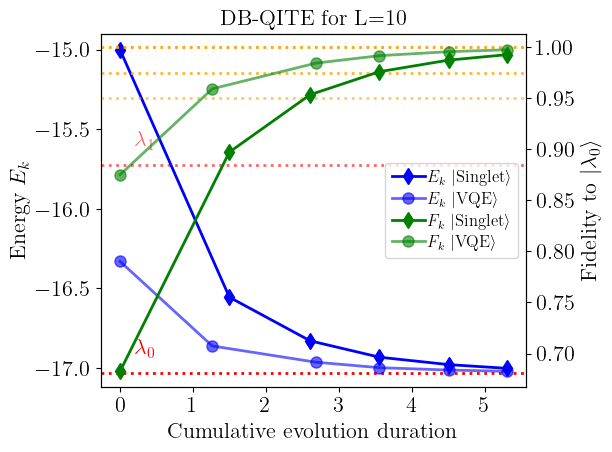

In [240]:
fig, ax1 = plt.subplots()
generate_plots(ax1,10)
plt.tight_layout()
plt.show()

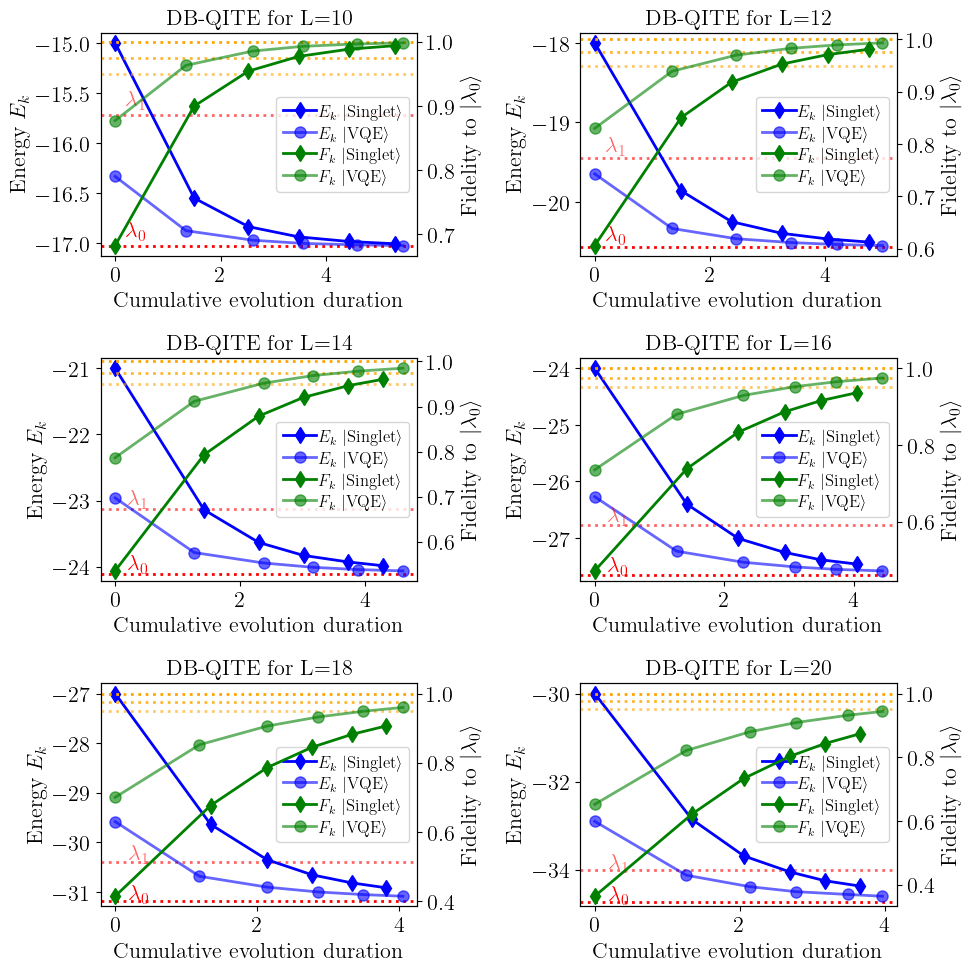

In [ ]:
# Create a figure with 6 subplots (3 rows, 2 columns)
fig, ((ax_10, ax_12), (ax_14, ax_16), (ax_18, ax_20)) = plt.subplots(3, 2, 
                                             figsize=(10, 10), 
                                             gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1,1,1]})

generate_plots(ax_10,10)
generate_plots(ax_12,12)
generate_plots(ax_14,14)
generate_plots(ax_16,16)
generate_plots(ax_18,18)
generate_plots(ax_20,20)

plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg.pdf")
plt.show()

## Generates plots for circuit data

In [291]:
def generate_circuit_plots(axC, L, type='VQE'):

    ###############################################################################
    # SUBPLOT 3: Circuit data 
    ###############################################################################
    results = results_dict[L]

    steps = [0,1,2,3,4,5]

    # Singlet
    u_count_S = np.array([results[0]["circuit_data"][0][k]['u3'] for k in steps])
    cz_count_S = np.array([results[0]["circuit_data"][0][k]['cz'] for k in steps])
    depth_S = np.array([results[0]["circuit_data"][2][k] for k in steps])

    # VQE
    u_count_V = np.array([results[1]["circuit_data"][0][k]['u3'] for k in steps])
    cz_count_V = np.array([results[1]["circuit_data"][0][k]['cz'] for k in steps])
    depth_V = np.array([results[1]["circuit_data"][2][k] for k in steps])

    scaling = 1000

    if type=='Singlet':
        axC.plot(steps, u_count_S/scaling, marker='d', color='#1f77b4', alpha=1.0, label='U3 count')
        axC.plot(steps, cz_count_S/scaling, marker='o', color='#ff7f0e', alpha=1.0, label='CZ count')
        axC.plot(steps, depth_S/scaling, marker='s', color='#2ca02c', alpha=1.0, label='Depth')

        axC.plot(steps, u_count_V/scaling, color='#1f77b4', marker='d', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, cz_count_V/scaling, color='#ff7f0e', marker='o', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, depth_V/scaling, color='#2ca02c', marker='s', alpha=0.6, linestyle='dashed')    
    else:
        axC.plot(steps, u_count_V/scaling, marker='d', color='#1f77b4', alpha=1.0, label='U3 count')
        axC.plot(steps, cz_count_V/scaling, marker='o', color='#ff7f0e', alpha=1.0, label='CZ count')
        axC.plot(steps, depth_V/scaling, marker='s', color='#2ca02c', alpha=1.0, label='Depth')

        axC.plot(steps, u_count_S/scaling, color='#1f77b4', marker='d', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, cz_count_S/scaling, color='#ff7f0e', marker='o', alpha=0.6, linestyle='dashed') 
        axC.plot(steps, depth_S/scaling, color='#2ca02c', marker='s', alpha=0.6, linestyle='dashed')        

    axC.set_xlabel(r"Steps $k$")
    axC.set_ylabel("Counts in thousands")

    axC.legend(loc="upper left", ncols=3, fontsize=15)
    axC.set_title(r"DB-QITE for L="+str(L))

    ###############################################################################
    # Inset table: circuit data GC
    ###############################################################################

    psi = E0_vec[L] # ground state
    if type=='Singlet':
        states = results[0]["statevectors"] # 0 Singlet, 1 VQE
    else:
        states = results[1]["statevectors"] # 0 Singlet, 1 VQE
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    # Data for the table
    rows = [' 0 ', '1', '2', '3', '4', '5']
    columns = (r'$k$','U3', 'CZ', 'Depth', r'$|\langle \Psi_k | \lambda_0 \rangle |^2$')
    if type=='Singlet':
        cell_text = [[rows[i], u_count_S[i], cz_count_S[i], depth_S[i], fidelities[i]] for i in range(6)]
    else:
        cell_text = [[rows[i], u_count_V[i], cz_count_V[i], depth_V[i], fidelities[i]] for i in range(6)]

    # Adjust column widths
    col_widths = [0.05, 0.1, 0.1, 0.1, 0.1]  # First column is wider

    # Add a table at the bottom of the axes
    tableC = axC.table(cellText=cell_text,
                        colLabels=columns,
                        loc='center left',
                        colWidths=col_widths)
    tableC.auto_set_font_size(False)
    tableC.set_fontsize(12)
    tableC.scale(1.5, 1.5)  # Adjust the scaling as needed


In [307]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(20)

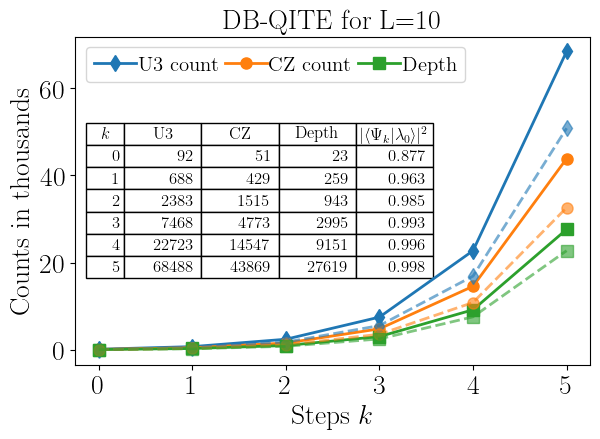

In [303]:
fig, axC = plt.subplots()
generate_circuit_plots(axC,10)
plt.tight_layout()
plt.show()

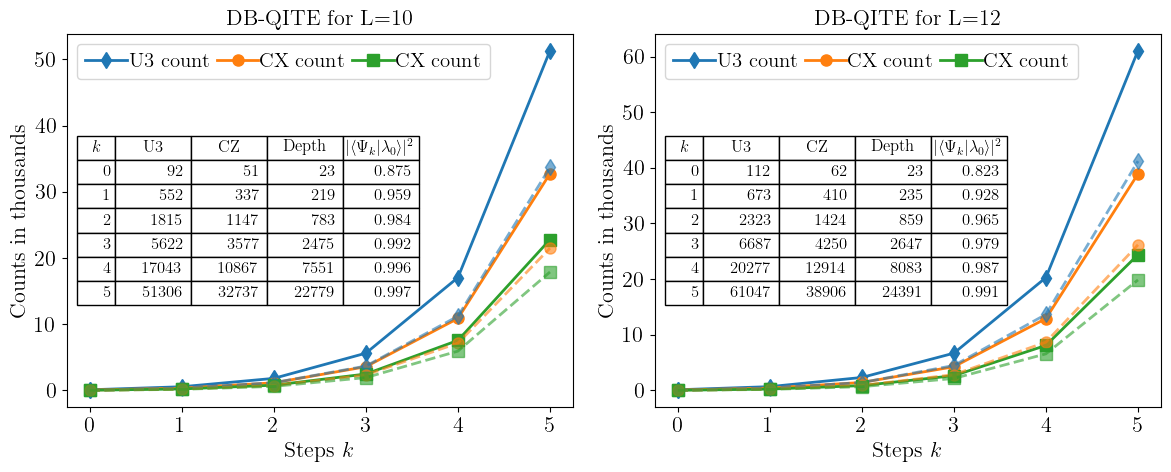

In [ ]:
# Create a figure with 4 subplots (2 rows, 2 columns)
fig, ((axC_10, axC_12)) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1,1]})
generate_circuit_plots(axC_10,10)
generate_circuit_plots(axC_12,12)
plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg_circuits.pdf")
plt.show()

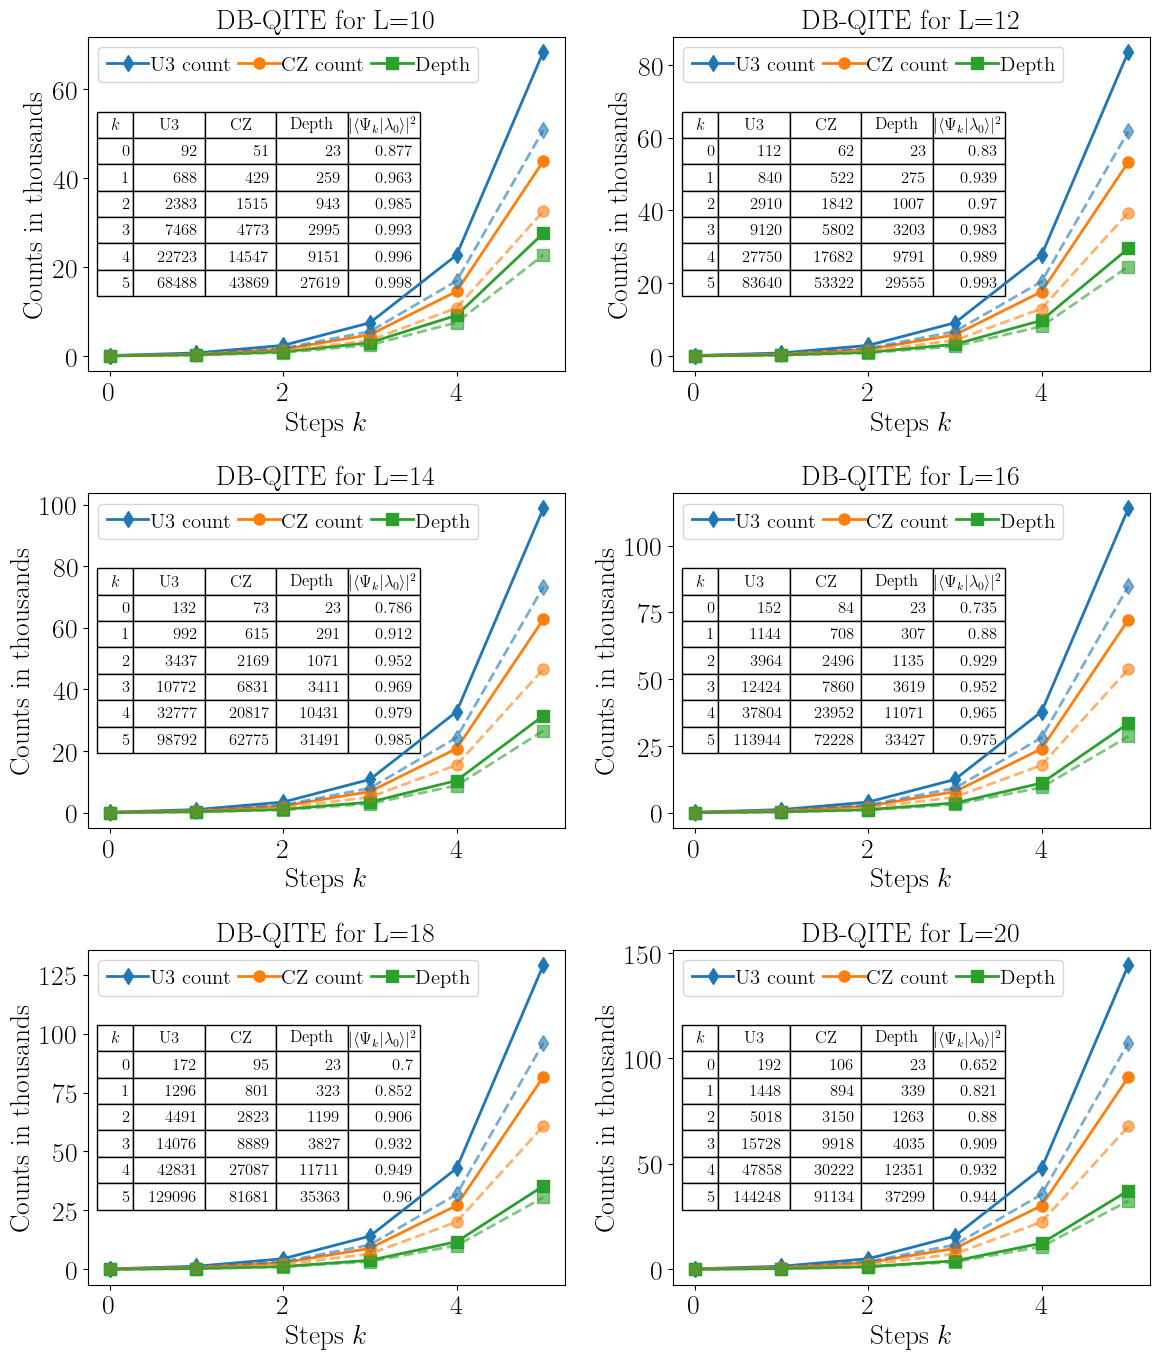

In [ ]:
# Create a figure with 6 subplots (3 rows, 2 columns)
fig, ((ax_10, ax_12), (ax_14, ax_16), (ax_18, ax_20)) = plt.subplots(3, 2, 
                                             figsize=(12, 14), 
                                             #figsize=(10, 10), 
                                             gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1,1,1]})

generate_circuit_plots(ax_10,10)
generate_circuit_plots(ax_12,12)
generate_circuit_plots(ax_14,14)
generate_circuit_plots(ax_16,16)
generate_circuit_plots(ax_18,18)
generate_circuit_plots(ax_20,20)

plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg_circuits.pdf")
plt.show()

## Plot evolution times

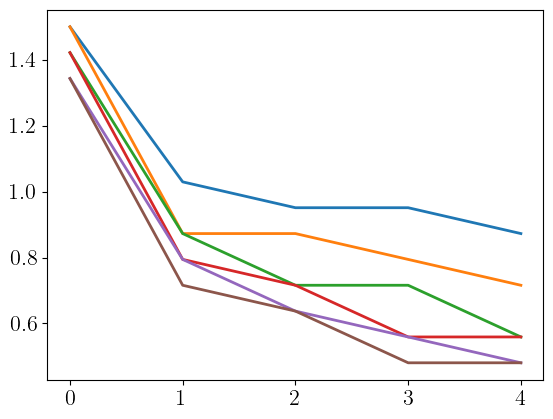

In [108]:

for L in range(10,22,2):
    times = results_dict[L][0]["evolution_times"]
    s = [times[k+1]-times[k] for k in range(len(times)-1)]
    plt.plot(s)

plt.show()

In [146]:
L=10

psi = E0_vec[L] # ground state
phi = results_dict[L][1]["statevectors"][0] # 0 Singlet, 1 VQE
F0 = np.abs(np.dot(psi.conj().transpose(),phi))**2

s = np.abs((E0_val[L]-E1_val[L])/12/E0_val[L]**3)
q = 1-100*s*F0*(E1_val[L]-E0_val[L])
q

np.float64(0.9974634573483704)

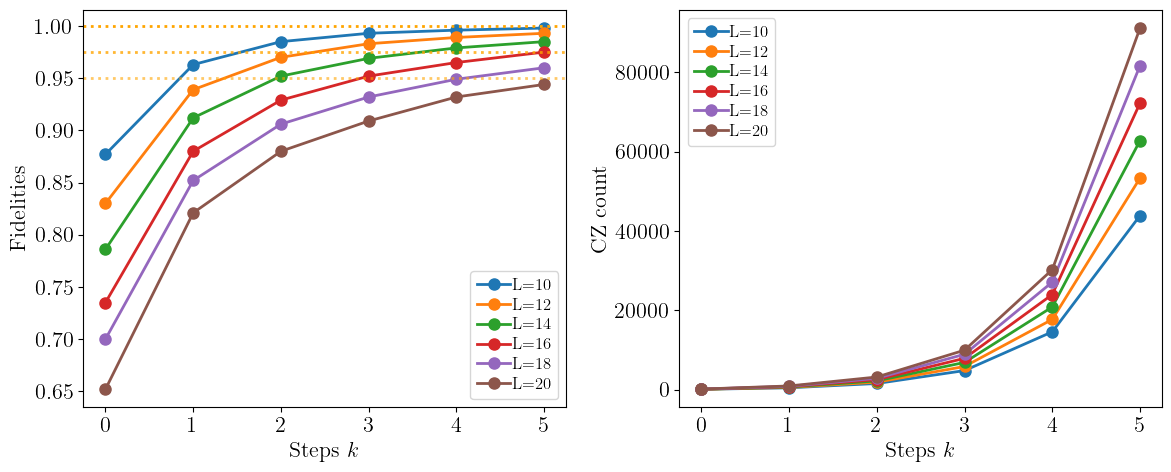

In [ ]:
import matplotlib.pyplot as plt

steps = list(range(0,6))

fig, ((axF, axCZ)) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1,1]})

for L in range(10,22,2):
    results = results_dict[L]

    psi = E0_vec[L] # ground state
    states = results[1]["statevectors"]
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    axF.plot(steps, fidelities, marker='o', label=r'L='+str(L))


axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF.axhline(y=0.975, color="orange", linestyle=':', alpha=0.8)
axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.6)

axF.legend(loc="best", fontsize=12)
axF.set_xlabel(r"Steps $k$")
axF.set_ylabel(r"Fidelities")


for L in range(10,22,2):
    results = results_dict[L]

    cz = np.array([results[1]["circuit_data"][0][k]['cz'] for k in steps])
    axCZ.plot(steps, cz, marker='o', label=r'L='+str(L))

axCZ.legend(loc="best", fontsize=12)
axCZ.set_xlabel(r"Steps $k$")
axCZ.set_ylabel(r"CZ count")

plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg_scaling.pdf")
plt.show()

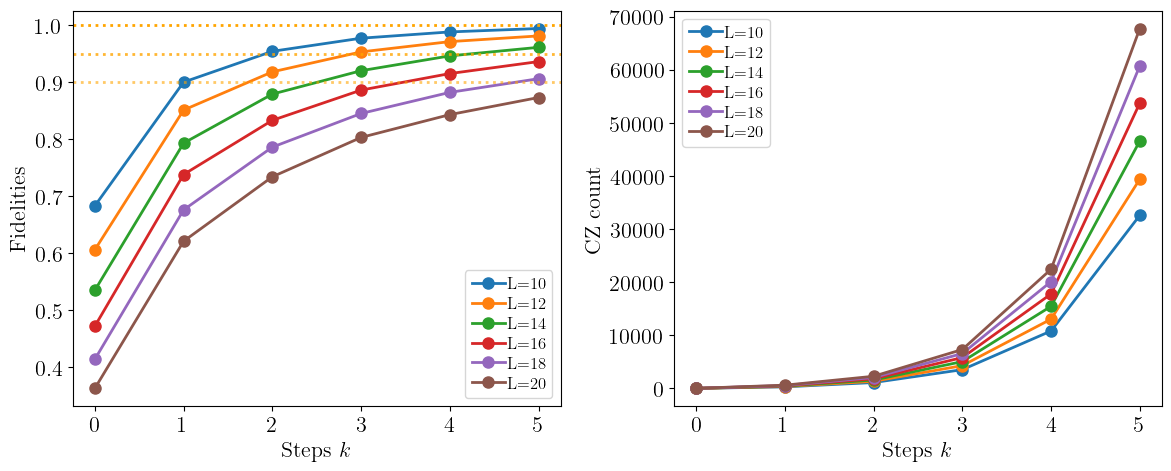

In [ ]:
import matplotlib.pyplot as plt

steps = list(range(0,6))

fig, ((axF, axCZ)) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1,1]})

for L in range(10,22,2):
    results = results_dict[L]

    psi = E0_vec[L] # ground state
    states = results[0]["statevectors"]
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    axF.plot(steps, fidelities, marker='o', label=r'L='+str(L))


axF.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF.legend(loc="best", fontsize=12)
axF.set_xlabel(r"Steps $k$")
axF.set_ylabel(r"Fidelities")


for L in range(10,22,2):
    results = results_dict[L]

    cz = np.array([results[0]["circuit_data"][0][k]['cz'] for k in steps])
    axCZ.plot(steps, cz, marker='o', label=r'L='+str(L))

axCZ.legend(loc="best", fontsize=12)
axCZ.set_xlabel(r"Steps $k$")
axCZ.set_ylabel(r"CZ count")

plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg_scaling_singlet.pdf")
plt.show()

## Generate plots QITE vs QPE

In [ ]:
# Load data (transpilation to {CZ,U3}), 2 steps 2nd order Trotterization
results_10 = load_data('data/benchmarks_2nd_L=10_04-17-19') 
results_12 = load_data('data/benchmarks_2nd_L=12_04-17-21')
results_14 = load_data('data/benchmarks_2nd_L=14_04-17-21')  
results_16 = load_data('data/benchmarks_2nd_L=16_04-17-22')  
results_18 = load_data('data/benchmarks_2nd_L=18_04-17-23')  
results_20 = load_data('data/benchmarks_2nd_L=20_04-18-11') 

results_QITE = dict()
results_QITE[10] = results_10
results_QITE[12] = results_12
results_QITE[14] = results_14
results_QITE[16] = results_16
results_QITE[18] = results_18
results_QITE[20] = results_20

results_QPE = dict()
results_QPE[0] = load_data('data/benchmarks_QPE_Singlet_04-25-14')
results_QPE[1] = load_data('data/benchmarks_QPE_VQE_04-25-15')


In [4]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(23)

In [5]:
def create_heisenberg_hamiltonian_(G, J):
    H = sum(J*( X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) ) for (i,j) in G.edges())
    return H

def calculate_spectra(L):
    G = nx.Graph()
    G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

    J = 1
    H = create_heisenberg_hamiltonian_(G, J)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')
    return eigenvalues, eigenvectors

x_val=list(range(4,22,2))

spectra = dict()
for L in x_val:
    spectra[L] = calculate_spectra(L) 

E0_val = dict()
E1_val = dict()
E0_vec = dict()
E1_vec = dict()

for L in x_val:
    E0_val[L] = spectra[L][0][0]
    E1_val[L] = spectra[L][0][1]

    E0_vec[L] = spectra[L][1][:,0]
    E1_vec[L] = spectra[L][1][:,1]

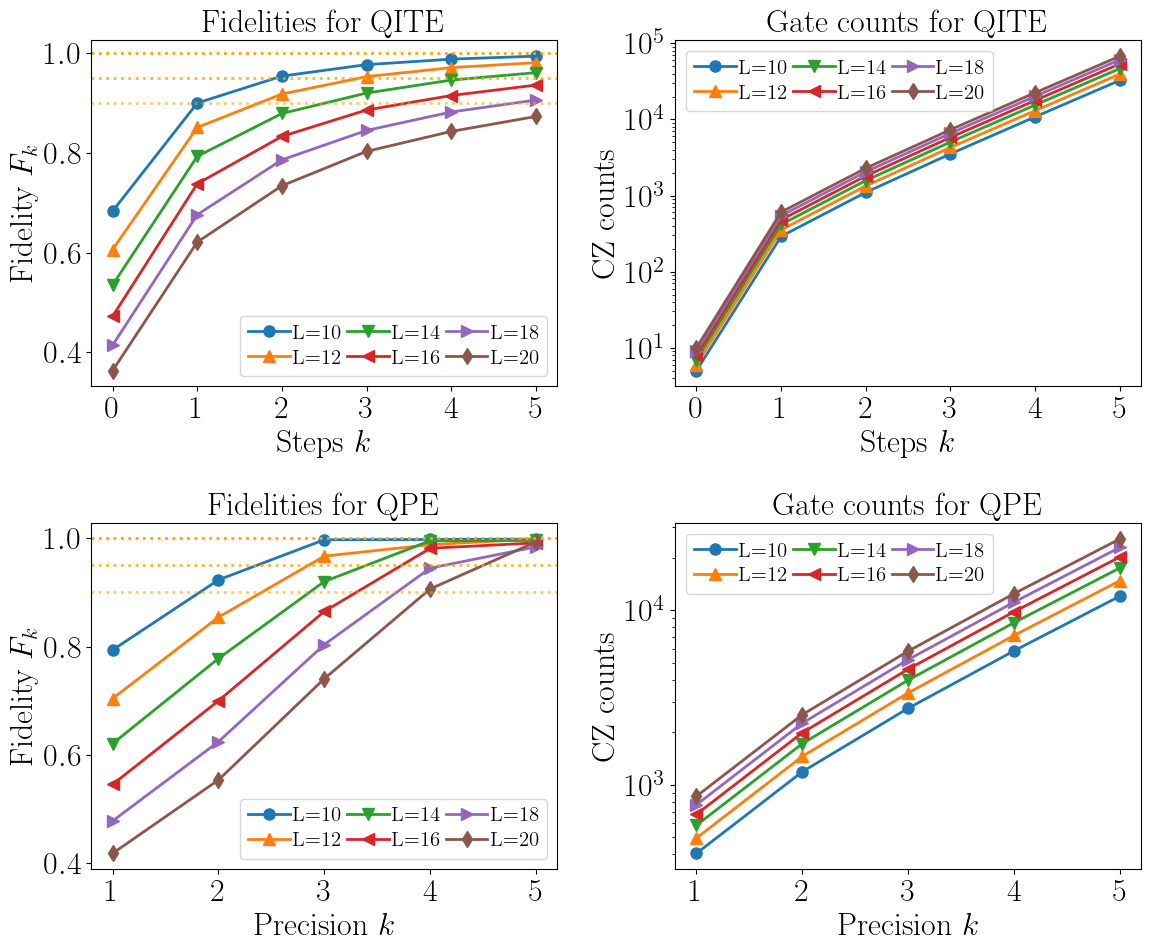

In [ ]:
import matplotlib.pyplot as plt

index = 0 # 0 Singlet, 1 VQE
markers = ['o', '^', 'v', '<', '>', 'd']

fig, ((axF_QITE, axCZ_QITE), (axF_QPE, axCZ_QPE)) = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"width_ratios": [1,1]})

###############################################################################
# SUBPLOT 1: Fidelity QITE
###############################################################################

steps = list(range(0,6))

for i,L in enumerate(list(range(10,22,2))):
    results = results_QITE[L]

    psi = E0_vec[L] # ground state
    states = results[index]["statevectors"]
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    axF_QITE.plot(steps, fidelities, marker=markers[i], label=r'L='+str(L))


axF_QITE.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF_QITE.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF_QITE.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF_QITE.legend(loc="best", ncols=3, fontsize=15)
axF_QITE.set_xticks(ticks = range(0, 6, 1))
axF_QITE.set_xlabel(r"Steps $k$")
axF_QITE.set_ylabel(r"Fidelity $F_k$")
axF_QITE.set_title(r"Fidelities for QITE")

###############################################################################
# SUBPLOT 2: CZ count QITE
###############################################################################

for i,L in enumerate(list(range(10,22,2))):
    results = results_QITE[L]

    cz = np.array([results[index]["circuit_data"][0][k]['cz'] for k in steps])
    axCZ_QITE.plot(steps, cz, marker=markers[i], label=r'L='+str(L))

axCZ_QITE.legend(loc="best", ncols=3, fontsize=15)
axCZ_QITE.set_yscale('log')
axCZ_QITE.set_xticks(ticks = range(0, 6, 1))
axCZ_QITE.set_xlabel(r"Steps $k$")
axCZ_QITE.set_ylabel(r"CZ counts")
axCZ_QITE.set_title(r"Gate counts for QITE")

###############################################################################
# Inset plot: Zoom in CZ count QITE
###############################################################################

#steps = list(range(0,4))

# Define inset axes
#axCZ_QITE_zoom = inset_axes(axCZ_QITE, width="45%", height="45%", loc="center left", bbox_to_anchor=(0.1, 0, 1, 1),
#                  bbox_transform=axCZ_QITE.transAxes,)

#for i,L in enumerate(list(range(10,22,2))):
#    results = results_QITE[L]

#    cz = np.array([results[index]["circuit_data"][0][k]['cz']/1000 for k in steps])
#    axCZ_QITE_zoom .plot(steps, cz, marker=markers[i], label=r'L='+str(L))

###############################################################################
# SUBPLOT 1: Fidelity QPE
###############################################################################

steps = list(range(1,6))

for i,L in enumerate(list(range(10,22,2))):
    fidelities = [results_QPE[index][L][k]['F0'] for k in steps]
    axF_QPE.plot(steps, fidelities, marker=markers[i], label=r'L='+str(L))

axF_QPE.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF_QPE.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF_QPE.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF_QPE.legend(loc="best", ncols=3, fontsize=15)
axF_QPE.set_xticks(ticks = range(1, 6, 1))
axF_QPE.set_xlabel(r"Precision $k$")
axF_QPE.set_ylabel(r"Fidelity $F_k$")
axF_QPE.set_title(r"Fidelities for QPE")

###############################################################################
# SUBPLOT 2: CZ count QPE
###############################################################################

for i,L in enumerate(list(range(10,22,2))):
    cz = [results_QPE[index][L][k]['ops']['cz'] for k in steps]
    axCZ_QPE.plot(steps, cz, marker=markers[i], label=r'L='+str(L))

axCZ_QPE.legend(loc="best", ncols=3, fontsize=15)
axCZ_QPE.set_yscale('log')
axCZ_QPE.set_xticks(ticks = range(1, 6, 1))
axCZ_QPE.set_xlabel(r"Precision $k$")
axCZ_QPE.set_ylabel(r"CZ counts")
axCZ_QPE.set_title(r"Gate counts for QPE")

plt.tight_layout()
#plt.savefig("plots/QITE_QPE_Heisenberg_Singlet_log.pdf")
#plt.savefig("plots/QITE_QPE_Heisenberg_VQE_log.pdf")
plt.show()